# 05 – Final Evaluation & Dashboard Preparation

Goal of this notebook:

- Load the stored test set and trained models.
- Reproduce final evaluation metrics.
- Generate visualisations for:
  - Predicted vs true RUL (test).
  - Classification performance.
  - Fleet-level risk view.
- Prepare any additional artifacts needed for the Streamlit dashboard.

In [12]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# --- Paths / environment ---
project_root = Path.cwd().parent
sys.path.append(str(project_root))
print("Project root:", project_root)

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

models_dir = project_root / "models"
test_features_path = project_root / "test_features.csv" 

TARGET_RUL_COL = "RUL"
CLASS_LABEL_COL = "fail_within_horizon"

test_features_path, models_dir


Project root: /Users/arnavthakur/Documents/Data Science Projects/Industrial_Equipment_Failure_Prediction


(PosixPath('/Users/arnavthakur/Documents/Data Science Projects/Industrial_Equipment_Failure_Prediction/test_features.csv'),
 PosixPath('/Users/arnavthakur/Documents/Data Science Projects/Industrial_Equipment_Failure_Prediction/models'))

In [13]:
df_test = pd.read_csv(test_features_path)
df_test.head()


,unit,cycle,RUL,setting_1_last,setting_2_last,setting_3_last,s_2_mean,s_2_std,s_2_min,s_2_max,...,s_21_mean,s_21_std,s_21_min,s_21_max,s_21_slope,s_21_fft_power,s_21_fft_top1,s_21_fft_top2,s_21_fft_top3,fail_within_horizon
0,81,30,210.0,-0.0009,0.0004,100.0,642.521000,0.333698,641.7,643.41,...,23.349173,0.058001,23.2123,23.4396,-0.001474,1.502099,0.591972,0.449322,0.422258,0
1,81,31,209.0,0.0010,-0.0001,100.0,642.536667,0.321133,641.7,643.41,...,23.347143,0.059506,23.2123,23.4396,-0.002036,1.597828,0.640881,0.408314,0.407929,0
2,81,32,208.0,-0.0005,0.0003,100.0,642.539333,0.322436,641.7,643.41,...,23.344437,0.061414,23.2123,23.4396,-0.002586,1.673928,0.652875,0.484282,0.417107,0
3,81,33,207.0,-0.0009,-0.0001,100.0,642.535000,0.323161,641.7,643.41,...,23.340100,0.064709,23.2123,23.4396,-0.003204,1.896724,0.530636,0.501876,0.447433,0
4,81,34,206.0,-0.0019,0.0001,100.0,642.538333,0.322341,641.7,643.41,...,23.336193,0.063202,23.2123,23.4396,-0.002886,1.774250,0.627473,0.557207,0.457069,0


In [14]:
lin_reg = joblib.load(models_dir / "linear_regression_rul.pkl")
xgb_reg = joblib.load(models_dir / "xgb_rul.pkl")
scaler = joblib.load(models_dir / "feature_scaler.pkl")

log_reg = joblib.load(models_dir / "logistic_failure.pkl")
xgb_clf = joblib.load(models_dir / "xgb_failure.pkl")


In [15]:
blacklist = {"unit", "cycle", TARGET_RUL_COL, CLASS_LABEL_COL}
feature_cols = [c for c in df_test.columns if c not in blacklist]

len(feature_cols), feature_cols[:5]


(138,
 ['setting_1_last', 'setting_2_last', 'setting_3_last', 's_2_mean', 's_2_std'])

In [16]:
X_test = df_test[feature_cols].values
y_test = df_test[TARGET_RUL_COL].values

X_test_scaled = scaler.transform(X_test)
y_pred_lr = lin_reg.predict(X_test_scaled)
y_pred_xgb = xgb_reg.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

mae_xgb, rmse_xgb


(29.36833128898978, np.float64(45.432420776210556))

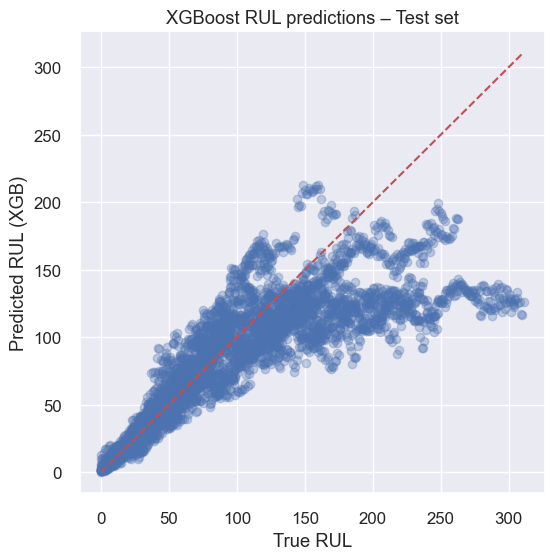

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL (XGB)")
plt.title("XGBoost RUL predictions – Test set")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()


In [18]:
y_test_cls = df_test[CLASS_LABEL_COL].values

y_pred_lr_cls = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

y_pred_xgb_cls = xgb_clf.predict(X_test)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Logistic
lr_acc = accuracy_score(y_test_cls, y_pred_lr_cls)
lr_prec = precision_score(y_test_cls, y_pred_lr_cls)
lr_rec = recall_score(y_test_cls, y_pred_lr_cls)
lr_f1 = f1_score(y_test_cls, y_pred_lr_cls)
lr_roc = roc_auc_score(y_test_cls, y_prob_lr)

# XGB
xgb_acc = accuracy_score(y_test_cls, y_pred_xgb_cls)
xgb_prec = precision_score(y_test_cls, y_pred_xgb_cls)
xgb_rec = recall_score(y_test_cls, y_pred_xgb_cls)
xgb_f1 = f1_score(y_test_cls, y_pred_xgb_cls)
xgb_roc = roc_auc_score(y_test_cls, y_prob_xgb)

metrics = {
    "lr_acc": lr_acc,
    "lr_prec": lr_prec,
    "lr_rec": lr_rec,
    "lr_f1": lr_f1,
    "lr_roc_auc": lr_roc,
    "xgb_acc": xgb_acc,
    "xgb_prec": xgb_prec,
    "xgb_rec": xgb_rec,
    "xgb_f1": xgb_f1,
    "xgb_roc_auc": xgb_roc,
}
metrics


{'lr_acc': 0.9401993355481728,
 'lr_prec': 0.7468030690537084,
 'lr_rec': 0.9419354838709677,
 'lr_f1': 0.833095577746077,
 'lr_roc_auc': 0.9892146586601098,
 'xgb_acc': 0.9711219013544595,
 'xgb_prec': 0.8800599700149925,
 'xgb_rec': 0.9467741935483871,
 'xgb_f1': 0.9121989121989122,
 'xgb_roc_auc': 0.9944432471616234}

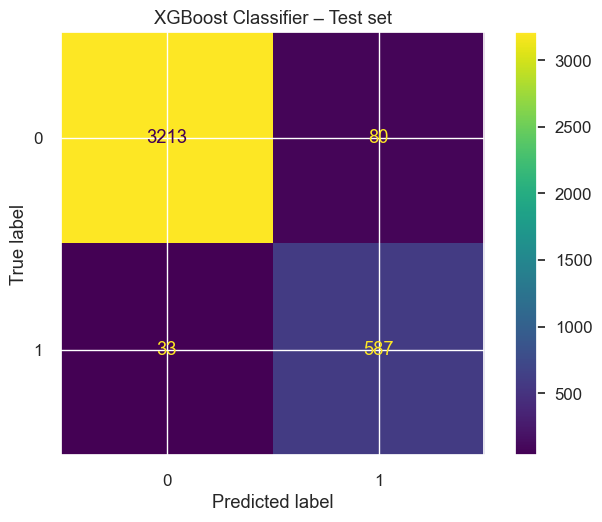

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test_cls, y_pred_xgb_cls)
plt.title("XGBoost Classifier – Test set")
plt.show()


In [20]:
df_test["pred_RUL"] = y_pred_xgb
df_test["risk_level"] = pd.cut(
    df_test["pred_RUL"],
    bins=[-1, 20, 50, df_test["pred_RUL"].max()],
    labels=["High", "Medium", "Low"],
)

df_latest = (
    df_test.sort_values(["unit", "cycle"])
           .groupby("unit")
           .tail(1)
           .reset_index(drop=True)
)

df_latest[["unit", "cycle", "RUL", "pred_RUL", "risk_level"]].head()


,unit,cycle,RUL,pred_RUL,risk_level
0,81,240,0.0,5.949133,High
1,82,214,0.0,1.514080,High
2,83,293,0.0,1.578977,High
3,84,267,0.0,5.204386,High
4,85,188,0.0,2.744997,High


In [21]:
dashboard_data_path = project_root / "data" / "processed" / "dashboard_test_latest.csv"
df_latest.to_csv(dashboard_data_path, index=False)
dashboard_data_path


PosixPath('/Users/arnavthakur/Documents/Data Science Projects/Industrial_Equipment_Failure_Prediction/data/processed/dashboard_test_latest.csv')